# Titanic Dataset : AdaBoost



The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.



## VARIABLE DESCRIPTIONS

- Pclass : Passenger Class  (1 = 1st; 2 = 2nd; 3 = 3rd)
- Survival  :  Survival  (0 = No; 1 = Yes)
- Name  : Name
- Sex  : Sex
- Age  : Age
- SibSp :  Number of Siblings/Spouses Aboard
- Parch  : Number of Parents/Children Aboard
- Ticket :  Ticket Number
- Fare  :  Passenger Fare (British pound)
- Cabin  :  Cabin
- Embarked  :  Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load DataSet

> Take a look over some summaries.

In [ ]:
data = pd.read_csv("/kaggle/input/titanic/train.csv",index_col = 0)
display(data.head())
display(data.info())
display(data.describe())

### First things first, let's look over the missing values and relation between them.

In [ ]:
display(data.isnull().sum())
missingno.matrix(data)
missingno.heatmap(data)

### Column "Cabin" contains massive Null values, so it's a good idea to drop that column.

In [ ]:
org = data.copy()
data.drop("Cabin",axis=1,inplace=True)

### The colums "SibSp" and "Parch" refers to the number of Siblings/Spouses and Parents/Childrens respectively. So they must be in Discrete amount and column "Embarked" contains Nominal data.

In [ ]:
display(data["Embarked"].unique())
display(data["SibSp"].unique())
data['Parch'].unique()

### Checking if there are any duplicate samples.

In [ ]:
display(data.duplicated().sum())
data[data.duplicated(["Ticket","Fare"])].sort_values("Ticket")

### No duplicate values so far.
### Column "Embarked" has only 2 missing values. So, we can impute them manually.

In [ ]:
data[data["Embarked"].isnull()]

In [ ]:
display(data[data["Ticket"]=="113572"])
data[data['Fare']==80]

### As there are only 2 missing values in "Embarked" column. Simply impute them with mode of the column.

In [ ]:
data.loc[data["Embarked"].isna(),"Embarked"] =  data["Embarked"].value_counts().index[0]

### Calculating the survival rate.

In [ ]:
survival_rate = data['Survived'].astype('int32').sum()/data.shape[0]
survival_rate

### Extremes of "Age" column(Should be between 0 - 110).

In [ ]:
print(data["Age"].min(),data["Age"].max())

### Creating a categorical column from "Age" column of analysis.

This is quite useful when you want to compare another continous variable against, it gives you better insights.

In [ ]:
data["AgeGrp"] = pd.cut(data["Age"],bins=[0,18,55,100],labels=["Child","Adult","Senior"])

### Fixing Nulls in "Age"column

#### There are 177 of them, at this amount it's suggested to come up with a strategy to impute them.

In [ ]:
data.isna().sum()

In [ ]:
temp = data.copy()

### Strategy to impute missing data in "Age" column:

> Observe the "Name" column, if contains name with salutations:
- Mr., Ms., Master, Miss.

> They all specify to a specific age range, for example, "Master" coresponds to Male of age between 0-18.

#### Now we can simply substitute Non-Null values from these salutations and can replace missing ones with mode(maximum frequency element) of substituted data.

In [ ]:
def fillAge(sal):
    
    
    mode = data[data["Name"].map(lambda x : sal in x)]["Age"].value_counts().reset_index().sort_values(["Age","index"],ascending = [False,False]).iloc[0,0]
    
    condition = (data["Name"].map(lambda x : sal in x)) & (data["Age"].isna())
    
    data.loc[condition,'Age'] = mode

salutation = ["Master.","Mrs.","Mr.","Miss."]

for i in salutation:
    fillAge(i)

In [ ]:
data.loc[data.Age.isna(),"Age"] = data.Age.mean()
display(data.isna().sum())

# Visualisation

### As we know the survival rate is around 38%, We might want to look hhow does other factors like Gender and Traveling Class effect the survival outcomes.

In [ ]:
sns.set(rc={'figure.facecolor':'white'})
sns.catplot(x="Pclass",col='Survived',hue="Sex",data=data,kind="count",aspect=0.9)


### Pretty straightforward, there is less chance of surviving if the passanger is male and belong to 3rd class, Womens and that's too of 1st class were given higher priority on lifeboat rescues.

### Moreover if look at the distribution of the Passenger's age, We discovered:

- Majority of the passengers were in the age range of 15-30.
- Majority of 3rd Class passengers died.
- Childs were of top priority too.

In [ ]:
sns.catplot("Survived","Age",hue='Pclass',data=data,kind="swarm",aspect=1.5)

### We only have 2 continuous features : "Age" and "Fare", is there any correlation between them? Well, it's sounds like there might be, specially childs could have lower fare for their tickets.

In [ ]:
display(np.corrcoef(data["Age"],data["Fare"]))
under18 = data[data["Age"]<=18]
np.corrcoef(under18["Age"],under18["Fare"])

### On contrary, it appears that there is no linear or minor relation between these two variables. The graph says the same.

In [ ]:
sns.jointplot("Age",'Fare',kind = "reg",joint_kws={"line_kws":{"color":"black"}},data=data)

### As discussed above:

> The colums "SibSp" and "Parch" refers to the number of Siblings/Spouses and Parents/Childrens respectively. So they must be in Discrete amount and column "Embarked" contains Nominal data.

### PMF would be good option to get insights about their distribution.

#### *Read more about PMF [here](https://en.wikipedia.org/wiki/Probability_mass_function).*

In [ ]:
def pmf(d):
    x = d.value_counts().sort_index() / len(d)
    return x

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
parch_pmf = pmf(data["Parch"])
sns.barplot(parch_pmf.index,parch_pmf,ax=ax[0])
ax[0].set_ylim(0,1)
sibsp_pmf = pmf(data["SibSp"])
sns.barplot(sibsp_pmf.index,sibsp_pmf,ax=ax[1])
ax[1].set_ylim(0,1)


### Looks like they are exponetially distributed. Next we will be looking for some other important insights like where are more people embarked for.


In [ ]:
sns.countplot("Embarked",data=data)

#### Majority of the passengers were embarked for Southampton 

### Next, by plotting "AgeGrp"(The column we formed earlier) with "Survived" we sense a hint that child were given priority while rescuing.

In [ ]:
sns.countplot("AgeGrp",hue="Survived",data=data)

### "Fare" vs Count comparision of Destinations:

### Important insights:
1. Majority of the passengers were bound for Southampton.
2. Fare were pretty high for Cherbourg.
3. Womens were charged more than mens.

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot("Embarked",data=data,palette=["#69e0cb"])
ax2 = ax.twinx()

ax3 = sns.pointplot("Embarked","Fare",data=data,hue="Sex",capsize=0.05,ax= ax2)


### By looking at the value distribution of "Age" column it looks like they are normally distributed.

### We can ensure that by plotting the CDF of the "Age" column over the actuall generated normal data with same mean and standard deviation. *Read more about CDF [here](https://en.wikipedia.org/wiki/Cumulative_distribution_function).*

- ### Observation : Data seems to be bit skewed toward a mid point. 

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
def ecdf(ser):
    xs = ser.sort_values(ascending=True)
    ys = np.linspace(0,1,num=xs.shape[0])
    xsn = np.random.normal(ser.mean(),ser.std(),ser.shape[0])
    
    ax[0].plot(xs,ys,marker='.',linestyle='none',ms=3)
    ax[0].plot(sorted(xsn),ys,marker='.',linestyle='none',ms=1.5,c='gray')
    sns.distplot(ser,ax=ax[1])
    ax[1].get_yaxis().set_ticks([])
ecdf(data["Age"])

In [ ]:
sns.regplot("SibSp","Parch",marker="+",data=data)

### How much of these factors really affects the survival chances?

### To answer this, we can quickly look over the logistic curves of "Age" and "Fare" columns, putting "Survived" as a target.

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (18,6))

sns.regplot(x="Fare",y="Survived",logistic = True,y_jitter=.04,data=data,ax=ax[0])
sns.regplot(x="Age",y="Survived",logistic = True,y_jitter=.04,data=data,ax=ax[1])

### Observations : 
- Plot 1 ("Fare") column: The curve is steep. Survival rate is pretty high for riches(i.e. higher class).

- Plot 2 ("Age") column: Slight negetive curve. Gives hint about younger ones were rescued first.

### Follow up: There are couple of high values in "Fare" column(Near 500 british pounds). What the curve will look like if we exclude those values?

In [ ]:
sns.regplot(x="Fare",y="Survived",logistic = True,y_jitter=.04,data=data[data["Fare"]<200])

### Cool, the curve is still steep. Now, it's time to train a model for this data.

# Predictive modeling

## We will be using AdaBoot (Adaptive Boost) algorithm for this task.

### Firstly what is AdaBoost?

> AdaBoost is an ensemble learning method (also known as “meta-learning”) which was initially created to increase the efficiency of binary classifiers. AdaBoost uses an iterative approach to learn from the mistakes of weak classifiers, and turn them into strong ones.

![AdaBoost](https://miro.medium.com/proxy/1*m2UHkzWWJ0kfQyL5tBFNsQ.png)

### Here, weak learner combines to create a powerfull strong learner.

### Now what is a weak learner in this case?

- Usually we use Decision Tree stump as a weak learner. Which just answer the single condition. Then combines the multiple Stumps to create boosted algorithm. Remember, the order of stumps matter!.

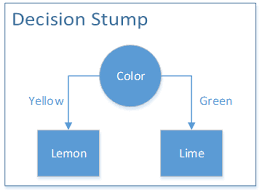

### Whichever stump gives the less error. They get more say in the algorithm, The error is obtained by Impurity Criterions like Gini, entropy etc.

![Impurity Criterion](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSkpyIpicBxFvKFMnmbhS58jJulREcyLteYhA&usqp=CAU)

#### *Read more about AdaBoost [here](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/)*.


In [ ]:
data

## Preparing the data:

### Firstly, remove the features which seems not that usefull for modeling, like "Name".

In [ ]:
dt = data.drop(["Name","Ticket","AgeGrp"],axis=1)

### Loading important libraries and determining the Feature and Target variables.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

X = dt.drop("Survived",axis=1)
y = dt["Survived"]

### Test-train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Looking at the distribution of target classes over the train and test variables. Looks good!

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.countplot(y_train,ax=ax[0])
sns.countplot(y_test,ax=ax[1])

### Encoding the categorical data.

In [ ]:
X_train = pd.get_dummies(X_train)

### Training the AdaBoost with 1000 estimators and 025 LR.

In [ ]:
clf = AdaBoostClassifier(n_estimators=1000,learning_rate = 0.25,random_state=21)
clf.fit(X_train,y_train)

In [ ]:
X_test = pd.get_dummies(X_test)

### Model Score over the test data.

In [ ]:
clf.score(X_test,y_test)

### Model score over the train data.

In [ ]:
clf.score(X_train,y_train)

### Extracting the probabilities.

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

# Classification report.

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

### ROC score, read more about ROC [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

In [ ]:
display(roc_auc_score(y_test,y_pred_proba))
roc_auc_score(y_test,ns_probs)


### Obtaining ROC curve.

In [ ]:
ns_fpr, ns_tpr, _ = roc_curve(y_test,ns_probs)
fpr, tpr, _ = roc_curve(y_test,y_pred_proba)

### Plotting ROC curve.

In [ ]:
plt.plot(ns_fpr,ns_tpr,linestyle="--",label="No Skill")
plt.plot(fpr,tpr,marker=".",label="AdaBoost")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()